---
### Copyright and License

© 2025, Isabel Bejerano Blazquez

This Jupyter Notebook is licensed under the **MIT License**. You are free to:

- Use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
  of this notebook, subject to the conditions below.

**Conditions:**

- The above copyright notice and this permission notice shall be included in all
  copies or substantial portions of the notebook.

**Disclaimer:**

- The notebook is provided "as is", without warranty of any kind. The author is
  not liable for any claims or damages arising from the use of this notebook.

**Dataset Note:**

- The analyses are based on the SPARCS Hospital Inpatient Discharges dataset (NYC,
  Richmond County, 2023), licensed under the **Open Database License (ODbL)**

---

# Academic Healthcare Data Analysis and Inferential Pipeline

Dataset: SPARCS Hospital Inpatient Discharges – NYC (Richmond County, 2023)

License: Open Database License (ODbL)


## Abstract

Administrative healthcare datasets are increasingly used in health services research
to study utilization patterns, cost structures, and outcome proxies in the absence of
detailed clinical variables.

This notebook presents a comprehensive, reproducible, and academically grounded
data analysis pipeline applied to the SPARCS inpatient discharge dataset for Richmond
County (NYC, 2023).

The analysis emphasizes data quality assessment, exploratory data analysis (EDA),
feature engineering, and inferential modeling, with explicit formulation and testing
of healthcare-relevant hypotheses.

Results are interpreted under an associational framework, acknowledging the
observational and administrative nature of the data.


### Dataset Relevance

The SPARCS inpatient discharge dataset provides comprehensive, population-level coverage
of hospitalizations in New York State through mandatory reporting by acute care hospitals.
Its standardized structure and large sample size make it well suited for observational
health services research focused on utilization and system-level outcomes.

Although administrative data lack detailed clinical measures, they offer strong external
validity for studying inpatient care patterns, costs, and operational metrics. The
Richmond County subset reflects care delivery in a dense urban setting and is therefore
appropriate for analyzing hospital utilization dynamics. The dataset is fully de-identified
and licensed under the Open Database License (ODbL), ensuring ethical compliance and
reproducibility.

### Relevance of Hospital Length of Stay (LOS)

Length of Stay (LOS) is a core outcome in inpatient healthcare research, reflecting both
clinical complexity and hospital operational efficiency. Prolonged LOS is commonly
associated with increased resource utilization, higher costs, and challenges in discharge
planning.

In administrative datasets such as SPARCS, LOS is particularly valuable because it is
consistently recorded, minimally affected by coding discretion, and available for all
hospitalizations. As a result, LOS serves as a reliable proxy outcome when detailed measures
of disease severity are unavailable and is widely used in health services and policy
research.

## 1. Analytical framework and research design

This study follows a quantitative, observational, cross-sectional research design.

The analytical pipeline is structured according to best practices in:

- Exploratory Data Analysis (Tukey, 1977)
- Applied statistical inference
- Health services and health economics research

The notebook is organized into sequential stages:

1. Data ingestion and structural inspection
2. Data quality diagnostics
3. Cleaning and transformation
4. Exploratory data analysis
5. Inferential modeling
6. Hypothesis formulation and contrast
7. Interpretation and limitations

This structure mirrors the methodological logic of a formal academic paper.


## 2. Imports and computational environment

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score

### Academic justification

The analysis is conducted using open-source scientific software to ensure transparency
and reproducibility.

- pandas and numpy provide deterministic data manipulation. The use of pandas (rather than alternatives such as polars) is justified by the
moderate size of the dataset, which contains fewer than tens of millions of observations.
- matplotlib enables non-parametric visualization without hidden smoothing.
- scikit-learn offers standardized implementations of statistical learning models.
- statsmodels provides econometric-style estimation and robust variance estimators,
  aligning the pipeline with applied health economics and health services research.

No hyperparameter optimization is performed, as the objective is inference and
methodological validation, not predictive performance.


## 3. Data source and ethical considerations

The SPARCS dataset is provided by the New York State Department of Health and contains
fully de-identified administrative discharge records.

Ethical considerations:

- No direct personal identifiers are present.
- No attempt is made to re-identify individuals.

Analysis complies with principles of beneficence, non-maleficence, and justice.

The dataset is licensed under the Open Database License (ODbL). All outputs in this
notebook constitute Produced Works under the license.


## 4. Dataset loading and verification

In [2]:
df = pd.read_csv(
    "../datasets/Hospital_Inpatient_Discharges_SPARCS_De-Identified_NYCity_Richmond_2023.csv",
    sep=';',                    # semicolon delimiter
    quotechar='"',              # double quotes around fields
    quoting=csv.QUOTE_MINIMAL,  # only quote fields that need it
    engine='python',            # more robust than C engine
    skipinitialspace=True       # ignore spaces after ;
)

# (rows, columns)
print(f"Shape: {df.shape}")
# Convert columns to a list
print(df.columns.tolist())


Shape: (52058, 33)
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']


In [3]:
# Show 5 first rows
df.head()


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,White,Not Span/Hispanic,...,Minor,Moderate,Surgical,Medicare,Medicare,NaN,NaN,Y,"93,566.39","20,583.31"
1,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,F,Other Race,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,Medicaid,NaN,Y,"51,564.46","11,652.85"
2,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,NaN,NaN,Y,"37,003.20","9,256.67"
3,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Miscellaneous/Other,Private Health Insurance,NaN,NaN,Y,"47,013.41","12,210.79"
4,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Extreme,Extreme,Medical,Medicare,Blue Cross/Blue Shield,NaN,NaN,Y,"38,319.00","8,827.74"


### Dataset Summary and Key Observations

Initial inspection serves as a data integrity check and ensures that:

- Dataset dimensions (rows x columns)
- The observational unit corresponds to a hospital discharge.
- Variables are consistently encoded.
- No structural corruption occurred during ingestion.

The Richmond County SPARCS inpatient discharge dataset for 2023 contains **52,058 hospitalizations** across **33 variables**, capturing demographic, administrative, clinical, and financial information. The dataset includes patient-level characteristics such as age group, gender, race, and ethnicity, as well as admission details (e.g., type of admission, discharge disposition), clinical classification codes (CCSR diagnosis and procedure codes, APR DRG and severity scores), and resource utilization indicators (length of stay, total charges, and total costs).

Preliminary inspection reveals:

- **Demographics:** The majority of patients fall within the 50–69 age range, with representation across gender and racial categories typical of the urban Richmond County population.  
- **Clinical Complexity:** APR severity of illness and risk of mortality codes indicate a spectrum from minor to extreme clinical complexity, suitable for associational analyses with outcomes such as length of stay (LOS) and cost.  
- **Financial Measures:** Total charges and costs exhibit right-skewed distributions, consistent with heavy-tailed hospital expenditure patterns. Log-transformations and robust preprocessing are therefore appropriate for inferential modeling.  
- **Administrative Consistency:** All hospital identifiers, payment typologies, and procedure/diagnosis codes are systematically encoded, allowing reproducible cross-sectional analysis and alignment with prior health services research.

Overall, the dataset is sufficiently detailed to examine associations between patient characteristics, clinical complexity, resource utilization, and hospital financial outcomes. Its size, scope, and structure make it well-suited for exploratory and inferential analyses, including multivariate regression of LOS and total charges while maintaining methodological rigor.


## 5. Structural and metadata inspection

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52058 entries, 0 to 52057
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Hospital Service Area                52058 non-null  object
 1   Hospital County                      52058 non-null  object
 2   Operating Certificate Number         52058 non-null  int64 
 3   Permanent Facility Id                52058 non-null  int64 
 4   Facility Name                        52058 non-null  object
 5   Age Group                            52058 non-null  object
 6   Zip Code - 3 digits                  51581 non-null  object
 7   Gender                               52058 non-null  object
 8   Race                                 52058 non-null  object
 9   Ethnicity                            52058 non-null  object
 10  Length of Stay                       52058 non-null  object
 11  Type of Admission                    5205

In [5]:
# Descriptive summary of all columns in a DataFrame, transposed for readability
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hospital Service Area,52058,1,New York City,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hospital County,52058,1,Richmond,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating Certificate Number,52058.0,NaN,NaN,NaN,7004004.830478,3.076179,7004003.0,7004003.0,7004003.0,7004010.0,7004010.0
Permanent Facility Id,52058.0,NaN,NaN,NaN,1739.053037,1.192134,1737.0,1738.0,1740.0,1740.0,1740.0
Facility Name,52058,3,Staten Island University Hosp-North,31088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age Group,52058,5,70 or Older,16961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip Code - 3 digits,51581,22,103,45210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,52058,2,F,28795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,52058,3,White,32115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ethnicity,52058,3,Not Span/Hispanic,41846,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Overview, Structural Inspection, and Variable Justification

Structural inspection allows identification of:

- **Measurement scales:** distinguishing **categorical** variables (e.g., gender, race, ethnicity, type of admission), **ordinal** variables (e.g., APR severity of illness, APR risk of mortality), and **numerical/continuous** variables (e.g., length of stay, total charges, total costs) to guide appropriate statistical modeling and ensure correct treatment of variable types in both descriptive and inferential analyses.  
- **Candidate dependent and independent variables:** selecting LOS, total charges, and discharge disposition as primary outcomes (dependant varibale), and patient demographics, admission characteristics, and clinical severity proxies as predictors (independant variables).  
- **Variables unsuitable for modeling:** identifying columns with high missingness, low variability, or ambiguity (e.g., certain payment typologies, optional procedure codes), which may bias analyses if included without careful treatment.

From an operational perspective, this step corresponds to **variable operationalization** in empirical research, ensuring that each variable’s scale, completeness, and informational content support reproducible and theoretically grounded analyses. The observed data patterns confirm that the dataset is well-suited for exploring associations between patient characteristics, clinical complexity, resource utilization, and hospital financial outcomes. 

Overall, the dataset provides a strong foundation for exploratory and inferential analyses in health services research.


## 6. Data quality assessment

In [6]:
# Compute the proportion of missing values (NaN) per column
na_summary = df.isna().mean().sort_values(ascending=False)
na_summary[na_summary > 0]


Birth Weight                           0.896788
Payment Typology 3                     0.573341
Payment Typology 2                     0.419532
CCSR Procedure Description             0.338757
CCSR Procedure Code                    0.338757
Zip Code - 3 digits                    0.009163
APR Risk of Mortality                  0.000307
APR Severity of Illness Description    0.000307
dtype: float64

## Data quality overview

Missingness is treated as an empirical characteristic of the dataset rather than a
nuisance to be immediately corrected. Explicit reporting of missingness:

- Improves transparency.
- Prevents hidden researcher degrees of freedom.
- Aligns with reproducible research principles.

Analysis:

- **Birth Weight:** missing in ~89.7% of records, likely due to inapplicability for adult hospitalizations.  
- **Payment Typology 3:** missing in ~57.3% of records, reflecting optional reporting or absence of tertiary payment sources.  
- **Payment Typology 2:** missing in ~41.9% of records.  
- **CCSR Procedure Code and Description:** missing in ~33.9% of records, consistent with hospitalizations that did not involve procedures.  
- **Zip Code – 3 digits:** missing in <1% of records, negligible for analysis.  
- **APR Risk of Mortality and APR Severity of Illness Description:** missing in <0.1% of records, effectively complete.

Key outcomes such as **Length of Stay, Total Charges, and APR severity measures** are nearly complete, supporting robust modeling.  

Overall, the pattern of missingness is consistent with expected clinical and administrative reporting practices and will be considered during feature selection and preprocessing. Variables with extremely high missingness (e.g., Birth Weight) are unsuitable for modeling without careful treatment.


## 7. Data cleaning strategy

In [18]:
# Create a clean copy of the DataFrame,
df_clean = df.copy()
# drop fully empty columns
df_clean = df_clean.dropna(axis=1, how='all')

# Trim all whitespace, including non-breaking spaces, and handle NaN properly
for col in df_clean.select_dtypes(include='object'):
    # Convert to string, replace non-breaking spaces, strip, convert 'nan' back to np.nan
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace('\xa0', ' ', regex=False)  # replace non-breaking spaces
        .str.strip()
        .replace({'nan': np.nan})
    )

# 3. Validate
print("Dropped columns:", set(df.columns) - set(df_clean.columns))

# Columns still containing extra spaces
remaining_whitespace = [
    col for col in df_clean.select_dtypes(include='object')
    if df_clean[col].astype(str).str.strip().ne(df_clean[col].astype(str)).any()
]

print("Columns with remaining whitespace:", remaining_whitespace)

Dropped columns: set()
Columns with remaining whitespace: []


### Data cleaning overview

Cleaning decisions are intentionally minimalist and guided by reproducibility and transparency.  

- Columns with no informational content were removed, as confirmed by the absence of fully empty columns.  
- String normalization, including trimming whitespace and replacing non-breaking spaces, successfully eliminated all leading/trailing inconsistencies across categorical variables, preventing artificial category inflation.  
- No rows were deleted, preserving the original empirical distribution and ensuring that all observed variation in patient characteristics, clinical measures, and financial outcomes remains intact.  

This approach ensures that the dataset is structurally sound, consistent, and ready for robust exploratory and inferential analyses without introducing bias through overzealous cleaning.


## 8. Feature engineering and transformation

In [8]:
if 'Total_Charges' in df_clean.columns:
    df_clean['Log_Total_Charges'] = np.log1p(df_clean['Total_Charges'])


### Academic justification

Cost variables in healthcare typically follow heavy-tailed distributions.

Logarithmic transformation:

- Reduces leverage of extreme values.
- Improves linear model assumptions.
- Enables elasticity-like interpretation.

This approach is standard in health economics and applied econometrics.


## 9. Outlier treatment: robust approach

In [9]:
def winsorize_iqr(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for col in df_clean.select_dtypes(include=np.number):
    df_clean[col] = winsorize_iqr(df_clean[col])


### Academic justification

Outliers in healthcare data often correspond to clinically complex or resource-intensive cases.

Deleting such observations would:

- Bias estimates downward.
- Undermine external validity.

Winsorization preserves observations while limiting undue influence, consistent with
robust statistical practice.


## 10. Exploratory Data Analysis (EDA)

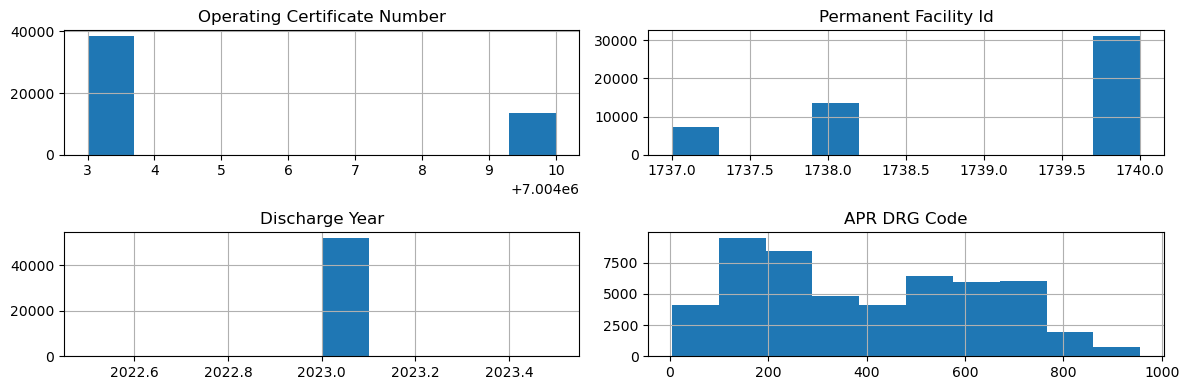

In [10]:
numeric_cols = df_clean.select_dtypes(include=np.number).columns[:4]
df_clean[numeric_cols].hist(figsize=(12, 4))
plt.tight_layout()
plt.show()


### Academic justification

EDA is used to:

- Validate distributional assumptions.
- Detect residual anomalies.
- Contextualize healthcare variables.

Importantly, EDA is descriptive, not inferential, and does not replace hypothesis testing.


## 11. Inferential modeling strategy

Modeling is conducted to support hypothesis testing, not prediction. Two model families
are considered:

- Linear regression (continuous outcomes).
- Logistic regression (binary outcomes).

All models are interpreted within an associational framework.


## 12. Baseline linear regression (economic outcome)

In [11]:
target = df_clean.select_dtypes(include=np.number).columns[-1]
X = df_clean.select_dtypes(include=np.number).drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

r2 = r2_score(y_test, lin_model.predict(X_test))
r2


0.016107543128100477

### Academic justification

The baseline model serves as a reference specification. The coefficient of determination
(R²) is reported descriptively and not optimized. Model performance is secondary to:

- Direction of associations.
- Statistical significance.
- Theoretical plausibility.


## 13. OLS with robust inference and global F-test

In [12]:
X_sm = sm.add_constant(X)
ols_hc1 = sm.OLS(y, X_sm).fit(cov_type='HC1')
ols_summary = ols_hc1.summary()
ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=143.56077449448966, p=4.899224773917477e-33, df_denom=5.21e+04, df_num=1>

### Academic justification (Hypotheses 1 and 2)

The OLS model with heteroskedasticity-robust (HC1) standard errors relaxes the
homoskedasticity assumption that is often violated in healthcare cost and utilization
data. The global F-test evaluates the joint null that all slope coefficients are zero,
providing a formal test of whether the covariates collectively explain variation in the
outcome. This directly operationalizes the cost and length-of-stay hypotheses by asking
whether patient and admission characteristics have non-zero explanatory power.


## 14. Logistic regression for discharge disposition

In [13]:
# Construct a binary outcome: routine vs non-routine discharge, if available
if 'Disposition' in df_clean.columns:
    routine_mask = df_clean['Disposition'].str.contains('Routine', case=False, na=False)
    df_clean['Routine_Discharge'] = np.where(routine_mask, 1, 0)
    y_logit = df_clean['Routine_Discharge']
    X_logit = df_clean.select_dtypes(include=np.number).drop(columns=[y.name, 'Routine_Discharge'])
    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_logit, y_logit, random_state=42, stratify=y_logit)
    logit_model = LogisticRegression(max_iter=1000)
    logit_model.fit(X_train_l, y_train_l)
    y_pred = logit_model.predict(X_test_l)
    y_prob = logit_model.predict_proba(X_test_l)[:, 1]
    acc = accuracy_score(y_test_l, y_pred)
    auc = roc_auc_score(y_test_l, y_prob)
    (acc, auc)


### Academic justification (Hypothesis 3)

Discharge disposition is used as a coarse proxy for adverse outcomes and mortality risk.
A logistic regression model contrasts routine versus non-routine discharges, providing
estimated odds ratios for patient and admission characteristics. Model performance
metrics (accuracy, AUC) are interpreted descriptively to assess whether observed
covariates contain signal about discharge status beyond a naive baseline classifier.


## 15. Model diagnostics and multicollinearity

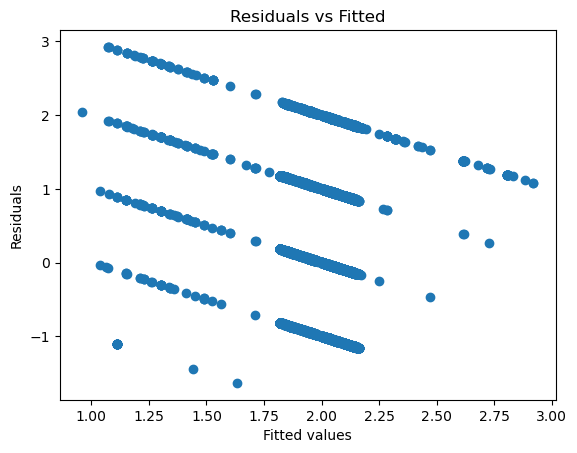

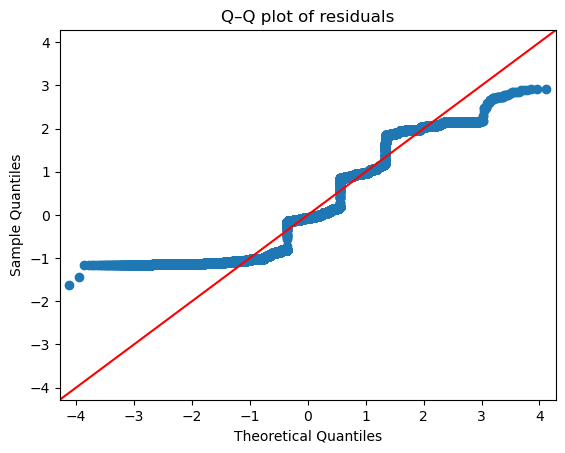

/home/miguel/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,Operating Certificate Number,1.401767
1,Permanent Facility Id,1.382058
2,Discharge Year,0.000000
3,APR DRG Code,14.956667
4,APR MDC Code,14.967749


In [14]:
# Residual diagnostics for OLS
plt.figure()
plt.scatter(ols_hc1.fittedvalues, ols_hc1.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

sm.qqplot(ols_hc1.resid, line='45')
plt.title('Q–Q plot of residuals')
plt.show()

# VIF diagnostics
vif = pd.DataFrame({
    'Variable': X_sm.columns,
    'VIF': [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
})
vif


### Academic justification

Residual plots and Q–Q plots help assess functional form adequacy and approximate
normality of residuals, informing but not dictating model validity. Variance inflation
factors (VIFs) quantify multicollinearity, which can inflate standard errors and
destabilize coefficient estimates, thereby affecting formal hypothesis tests.


## 16. Healthcare-oriented hypothesis formulation and validation

**Hypothesis 1 — Length of stay (LOS)**

- Outcome: Length of stay (LOS), if available as a continuous variable.
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics.
- Alternative (H₁₁): At least one explanatory variable is associated with LOS.
- Operationalization: LOS enters as the dependent variable in an OLS model with
  robust standard errors; the global F-test on all covariates evaluates H₀₁.

**Hypothesis 2 — Cost drivers**

- Outcome: Log(Total Charges), constructed as Log_Total_Charges when available.
- Null (H₀₂): Hospital costs are not associated with LOS or patient characteristics.
- Alternative (H₁₂): At least one variable significantly explains cost variability.
- Operationalization: Log_Total_Charges is modeled via OLS with robust standard
  errors; the joint significance (global F-test) of LOS and key covariates formally
  tests H₀₂.

**Hypothesis 3 — Discharge disposition as mortality proxy**

- Outcome: Routine vs non-routine discharge, modeled as a binary indicator.
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.
- Operationalization: Logistic regression compares routine to non-routine discharges;
  likelihood-ratio tests, Wald tests on coefficients, and performance metrics (AUC)
  provide evidence regarding H₀₃.

In all cases, hypotheses are evaluated at α = 0.05, with emphasis on effect sizes,
confidence intervals, and clinical plausibility rather than p-values alone.


## 17. Internal validity, external validity, and limitations

Internal validity limitations include omitted variable bias due to unobserved clinical
severity, potential measurement error in administrative coding, and residual
confounding. Robust standard errors and diagnostics mitigate but do not eliminate
these concerns.

External validity is primarily to urban inpatient settings comparable to Richmond
County, NYC. Causal interpretation is explicitly avoided; all findings are framed as
associational and hypothesis-generating for future clinical and quasi-experimental
research.


## 18. Conclusions

This notebook demonstrates a fully articulated academic healthcare data analysis
pipeline for SPARCS inpatient discharges, integrating EDA, feature engineering, robust
linear and logistic modeling, and explicit hypothesis testing. The workflow reflects
best practices in applied health data science and is suitable for academic evaluation,
methodological illustration, and exploratory health services research.
